# Introduction

This notebook demonstrates two approaches to nanocrystal segmentation:
1. Virtual dark-field (VDF) imaging-based segmentation
2. Non-negative matrix factorisation (NMF)-based segmentation

The segmentation is demonstrated on a SPED dataset of partly overlapping MgO nanoparticles, where some of the particles share the same orientation. The SPED data can be found in [1]. An article including explanation of the methods and discussions of the results is under review. 

[1] T Bergh. (2019) *Scanning precession electron diffraction data of partly overlapping magnesium oxide nanoparticles.* doi: 10.5281/zenodo.3382874.

This functionaility was introduced in pyxem-0.10.0 (November 2019) and has been checked to run. Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

# Contents

1. <a href='#gen'> Setting up, Loading Data, Pre-processing</a>
2. <a href='#vdf'> Virtual Image Based Segmentation</a>
3. <a href='#nmf'> NMF Based Segmentation</a>

# <a id='gen'></a> 1. Setting up, Loading Data, Pre-processing

Import pyxem and other required libraries

In [1]:
%matplotlib qt
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
import pyxem as pxm

Load demonstration data

In [2]:
dp = pxm.load_hspy('MgO2_16_TX5_c_bin2,2.hdf5',
                  lazy=False,
                  assign_to='electron_diffraction2d')

Plot data to inspect

In [3]:
dp.plot(cmap='magma_r')

Remove the background

In [4]:
sigma_min = 1.7
sigma_max = 13.2

dp_rb = dp.remove_background('gaussian_difference', 
                             sigma_min=sigma_min, 
                             sigma_max=sigma_max)

In [5]:
dp_rb.plot(cmap='magma_r')

Find the position of the direct beam in background subtracted data.

In [6]:
shifts = dp_rb.center_direct_beam(method='cross_correlate',
                                  square_width=15,
                                  return_shifts=True,
                                  radius_start=2,
                                  radius_finish=6)

Apply the same shifts to the raw data.

In [9]:
dp.align2D(shifts=shifts, crop=False, fill_value=0)

Set calibrations

In [10]:
scale = 0.03246
scale_real = 2.56
dp.set_diffraction_calibration(scale)
dp.set_scan_calibration(scale_real)

dp_rb.set_diffraction_calibration(scale)
dp_rb.set_scan_calibration(scale_real)

# <a id='vdf'></a> 2. Virtual Image Based Segmentation

Find all diffraction peaks for all PED patterns. 
The parameters were found by interactive peak finding:

`peaks = dp_rb.find_peaks_interactive(imshow_kwargs={'cmap': 'magma_r'})`

In [12]:
peaks = dp_rb.find_peaks(method='laplacian_of_gaussians', 
                         min_sigma=0.7,
                         max_sigma=10,
                         num_sigma=30, 
                         threshold=0.046, 
                         overlap=0.5, 
                         log_scale=False,
                         exclude_border=True)

/home/hremadmin/anaconda3/envs/pyxem/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/hremadmin/anaconda3/envs/pyxem/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/hremadmin/anaconda3/envs/pyxem/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/hremadmin/anaconda3/envs/pyxem/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


Visualise the number of diffraction peaks found pr. probe position

In [13]:
diff_map = peaks.get_diffracting_pixels_map()
diff_map.plot()

Refine the peak positions

In [14]:
from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.diffraction_vectors import DiffractionVectors

In [18]:
dp_padded = np.zeros((dp.data.shape[0],dp.data.shape[1],
                     dp.data.shape[2]+12,dp.data.shape[2]+12))
dp_padded[:,:,6:dp.data.shape[2]+6,6:dp.data.shape[2]+6] = dp_rb.data
dp_padded = pxm.ElectronDiffraction2D(dp_padded)
dp_padded.set_diffraction_calibration(scale)
dp_padded.set_scan_calibration(scale_real)

Padding is used so that peaks at the edges of the diffraction patterns are treated correctly.

In [19]:
refine_gen = SubpixelrefinementGenerator(dp_padded, peaks)
peaks_refined = DiffractionVectors(
    refine_gen.center_of_mass_method(square_size=4))
peaks_refined.axes_manager.set_signal_dimension(0)

Find the unique diffraction peaks by clustering

In [20]:
distance_threshold = scale*0.89
min_samples = 10

unique_peaks = peaks_refined.get_unique_vectors(method='DBSCAN',
    distance_threshold=distance_threshold, min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

56  unique vectors were found.


Visualise the detected unique peaks by plotting them on the maximum of the signal. 

In [21]:
radius_px = dp_rb.axes_manager.signal_shape[0]/2
reciprocal_radius = radius_px * scale

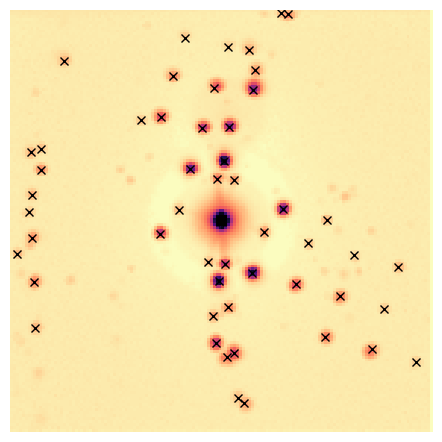

In [22]:
unique_peaks.plot_diffraction_vectors(
    method='DBSCAN',
    unique_vectors=unique_peaks,
    distance_threshold=distance_threshold,
    xlim=reciprocal_radius,
    ylim=reciprocal_radius,
    min_samples=min_samples,
    image_to_plot_on=dp_rb.max(),
    image_cmap='magma_r',
    plot_label_colors=False)

Visualise both the clusters and the unique peaks obtained after DBSCAN clustering. 

*NB The cluster colors are randomly generated, so run it again if it is hard to discern two close clusters.*

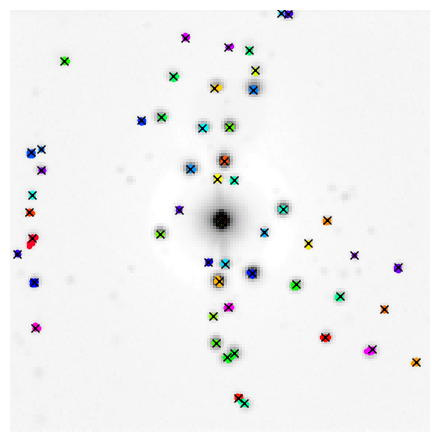

In [23]:
peaks_refined.plot_diffraction_vectors(
    method='DBSCAN',
    xlim=reciprocal_radius, 
    ylim=reciprocal_radius,
    unique_vectors=unique_peaks, 
    distance_threshold=distance_threshold,
    min_samples=min_samples, 
    image_to_plot_on=dp_rb.max(), 
    image_cmap='gray_r',
    plot_label_colors=True, 
    distance_threshold_all=scale*0.1)

Filter the unique vectors by magnitude in order to exclude the direct beam from the following analysis

In [24]:
gmags = unique_peaks.get_magnitudes()
gmags.data[gmags.data<10*scale] = 0
Gs = unique_peaks.data[np.where(gmags)]
Gs = pxm.DiffractionVectors(Gs)
print(np.shape(Gs)[0], ' unique vectors.')
Gs.axes_manager.set_signal_dimension(0)

52  unique vectors.


Plot the unique vectors

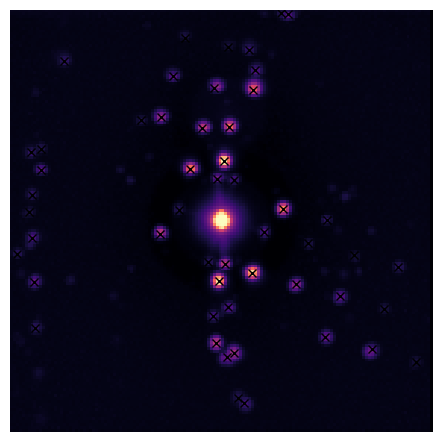

In [25]:
Gs.plot_diffraction_vectors(unique_vectors=Gs,
                            distance_threshold=distance_threshold,
                            xlim=reciprocal_radius,
                            ylim=reciprocal_radius,
                            min_samples=min_samples,
                            image_to_plot_on=dp_rb.max(),
                            image_cmap='magma',
                            plot_label_colors=False)

Optionally save and load the unique peaks

`np.save('peaks.npy', Gs.data)
Gs = np.load('peaks.npy', allow_pickle=True)
Gs = pxm.DiffractionVectors(Gs)
Gs.axes_manager.set_signal_dimension(0)`

### Calculate VDF images for all unique peaks

In [27]:
from pyxem.generators.vdf_generator import VDFGenerator

In [28]:
radius=scale*2

vdfgen = VDFGenerator(dp_rb, Gs)
VDFs = vdfgen.get_vector_vdf_images(radius=radius)

In [29]:
VDFs.plot(cmap='magma', scalebar=False)

## 1(b) Watershed segmentation

First find adequate parameters by looking at watershed segmentation of a single VDF image.

In [30]:
from pyxem.utils.segment_utils import separate_watershed

In [31]:
min_distance = 5.5
min_size = 10
max_size = None
max_number_of_grains = np.inf
marker_radius = 2
exclude_border = 2

In [32]:
i = 27
sep_i = separate_watershed(
    VDFs.inav[i].data, min_distance=min_distance, min_size=min_size,
    max_size=max_size, max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, marker_radius=marker_radius,
    threshold=True, plot_on=True)

Perform segmentation on all the VDF images

In [33]:
segs = VDFs.get_vdf_segments(min_distance=min_distance,
                                  min_size=min_size,
                                  max_size = max_size,
                                  max_number_of_grains = max_number_of_grains,
                                  exclude_border=exclude_border,
                                  marker_radius=marker_radius,
                                  threshold=True)
print(np.shape(segs.segments)[0],' segments were found.')

174  segments were found.


In [34]:
segs.segments.plot(cmap='magma_r')

## 1(c) Correlation of the VDF image segments

Calculate normalised cross-correlations between the VDF image segments to identify those that are related to the same crystal. If the correlation value exceeds *corr_threshold* for certain segments, those segments are summed. These segments are discarded if the number of these segments are below *vector_threshold*, as this number corresponds to the number of detected diffraction peaks associated with the single crystal. The *vector_threshold* criteria is included to avoid including segment images resulting from noise or incorrect segmentation. 

In [35]:
corr_threshold=0.7
vector_threshold=5
segment_threshold=4

In [36]:
corrsegs = segs.correlate_vdf_segments(
    corr_threshold=corr_threshold, vector_threshold=vector_threshold,
    segment_threshold=segment_threshold)
print(np.shape(corrsegs.segments)[0],' correlated segments were found.')

  0%|          | 0/174 [00:01<?, ?it/s]

7  correlated segments were found.


Simulate virtual diffraction patterns for each summed segment

In [37]:
sigma = scale*1.5

virtual_sig = corrsegs.get_virtual_electron_diffraction(
    calibration=scale, shape=(int(radius_px*2), int(radius_px*2)), sigma=sigma)
virtual_sig.set_diffraction_calibration(scale)
#hs.plot.plot_signals([corrsegs.segments, virtual_sig], cmap='magma_r')

Plot the final results from the VDF image-based segmentation

In [38]:
hs.plot.plot_images(corrsegs.segments, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(virtual_sig, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right': 0.78})

# <a id='nmf'></a> 3. NMF Based Segmentation

For the NMF-based segmentation, the required pre-processing, binning and alignment, were done at the start of the notebook. 

#### Create a signal mask for the direct beam
Create a signal mask so that the region in the centre of each PED pattern, including the direct beam, can be excluded in the machine learning. 

In [40]:
dpm = pxm.Diffraction2D(dp.inav[0,0])
signal_mask = dpm.get_direct_beam_mask(radius=10)
signal_mask.plot()

#### Perform single value decomposition (SVD)

In [41]:
dp.change_dtype('float32')
dp.decomposition(algorithm='svd',
                 normalize_poissonian_noise=True,
                 centre='variables',
                 signal_mask=signal_mask.data)

In [42]:
dp.plot_decomposition_results()

#### Investigate the scree plot and use it as a guide to determine the number of components

In [43]:
num_comp=11

ax = dp.plot_explained_variance_ratio(n=200, threshold=num_comp,
                                      hline=True, xaxis_labeling='ordinal',
                                      signal_fmt={'color':'k', 'marker':'.'}, 
                                      noise_fmt={'color':'gray', 'marker':'.'})

### NMF

In [44]:
dp.decomposition(normalize_poissonian_noise=True,
                 algorithm='nmf',
                 output_dimension=num_comp,
                 centre = 'variables',
                 signal_mask=signal_mask.data)

In [45]:
dp_nmf = dp.get_decomposition_model(components=np.arange(num_comp))
factors = dp_nmf.get_decomposition_factors()
loadings = dp_nmf.get_decomposition_loadings()

Plot the NMF results

In [46]:
hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})

Discard the components related to background (\#0) and to the carbon film (\#4)

In [47]:
from hyperspy.signals import Signal2D

In [48]:
factors = Signal2D(np.delete(factors.data, [0, 4], axis = 0))
loadings = Signal2D(np.delete(loadings.data, [0, 4], axis = 0))

In [49]:
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

## 2(b) Correlation

NMF often leads to splitting of some crystals into several components. Therefore the correlation between loadings and between component patterns are calculated, and if both the correlation values for loadings and factors exceed threshold values, those loadings and factors are summed. 

#### Investigate the normalised cross-correlations
Calculate the matrix of normalised cross-correlation for both the loadings and patterns first, to find suitable correlation threshold values. 

In [51]:
from pyxem.signals.segments import LearningSegment

In [52]:
learn = LearningSegment(factors=factors, loadings=loadings)

In [53]:
corr_th_factors = 0.45
corr_th_loadings = 0.3

Perform correlation and summation of the factors and loadings

In [54]:
learn_corr = learn.correlate_learning_segments(corr_th_factors=corr_th_factors,
                                               corr_th_loadings=corr_th_loadings)

Plot the NMF reuslts after correlation and summation

In [56]:
hs.plot.plot_images(learn_corr.loadings, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(learn_corr.factors, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

## 2(c) Watershed segmentation

Since one single loading map can contain several crystals, watershed segmentation is performed on the correlated loadings. 

First investigate how the parameters influence the segmentation on
one single loading map.

In [ ]:
from pyxem.utils.segment_utils import separate_watershed

In [ ]:
min_distance = 10
min_size = 50
max_size = None
max_number_of_grains = np.inf
marker_radius = 2
exclude_border = 1
threshold = True

In [ ]:
i =1
sep_i = separate_watershed(
    learn_corr.loadings.data[i], min_distance=min_distance,
    min_size=min_size, max_size=max_size, 
    max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, 
    marker_radius=marker_radius, threshold=True, plot_on=True)

Set a threshold for the minimum intensity value that a loading segment must contain in order to be kept. 

In [ ]:
min_intensity_threshold = 10000

In [ ]:
learn_corr_seg = learn_corr.separate_learning_segments(
    min_intensity_threshold=min_intensity_threshold,
    min_distance = min_distance, min_size = min_size,
    max_size = max_size, 
    max_number_of_grains = max_number_of_grains,
    exclude_border = exclude_border,
    marker_radius = marker_radius, threshold = True)

Plot the final results from the NMF-based segmentation

In [ ]:
hs.plot.plot_images(learn_corr_seg.loadings, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(learn_corr_seg.factors, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})